In [6]:
import astropy.io.fits as fits #To read FITS files
import matplotlib.pyplot as plt #To visualize FITS files and the plot at the end
import numpy as np #To analyze data

In [19]:
# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

In [3]:
images = []
#I'm going to append the images from the .tar file into this empty list.

for i in range(1, 29, 1):
    #The second argument must be put to 1 more than the files because the function will not include it as an endpoint.
    
    images.append('d' + str(i) + '.fits')
    
print(images)
#Checking to make sure the loop included all the files.

['d1.fits', 'd2.fits', 'd3.fits', 'd4.fits', 'd5.fits', 'd6.fits', 'd7.fits', 'd8.fits', 'd9.fits', 'd10.fits', 'd11.fits', 'd12.fits', 'd13.fits', 'd14.fits', 'd15.fits', 'd16.fits', 'd17.fits', 'd18.fits', 'd19.fits', 'd20.fits', 'd21.fits', 'd22.fits', 'd23.fits', 'd24.fits', 'd25.fits', 'd26.fits', 'd27.fits', 'd28.fits']


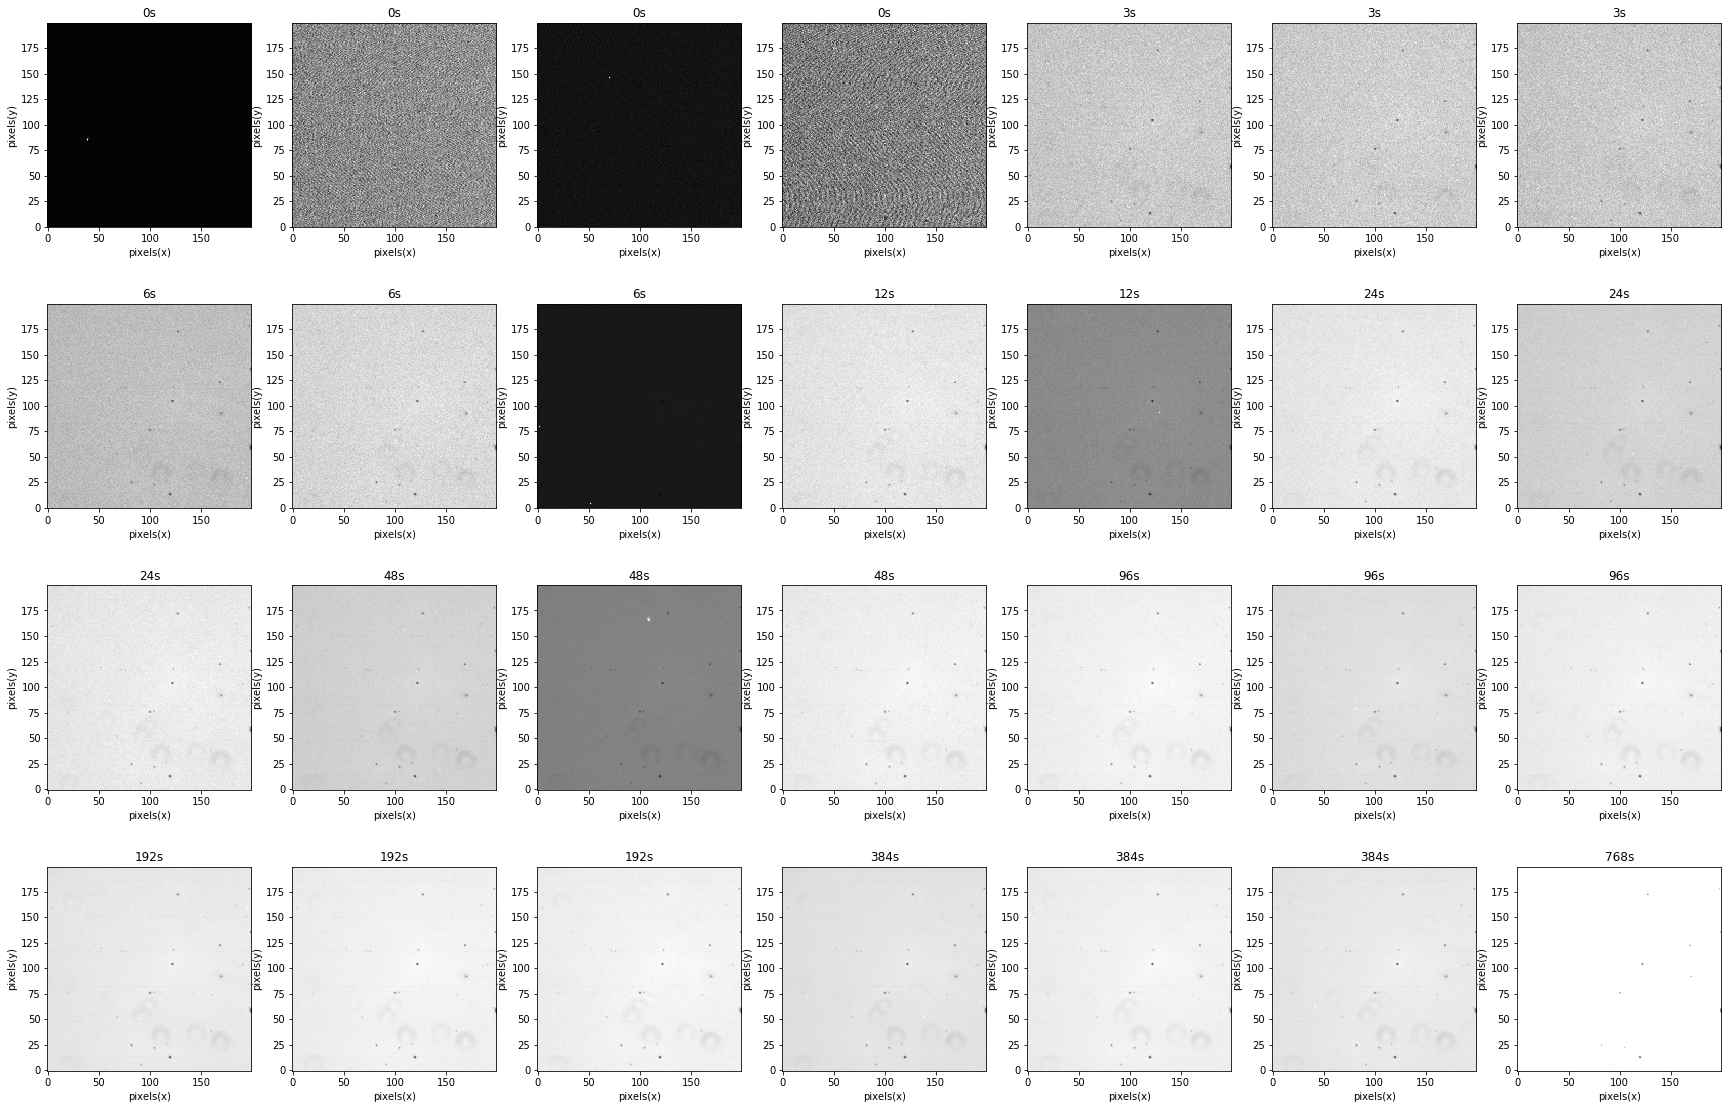

In [7]:
%matplotlib inline
plt.figure(figsize = (30, 25))
columns = 7

clean_data_list = []
#Saving the clean data into a nested list so I don't have to load in the images every time I operate

for i, image in enumerate(images):
    #Using a for loop to print the images
    
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    
    data = fits.getdata(image)[400:600,400:600]
    #The selected region should only contain clean data that does not contain hot pixels. 
    #Images 1, 3, 11, and 18 appear to have some bright spots, but I checked them in js9 and they are only around 1000 ADU
    
    clean_data_list.append(data.flatten())
    #Appending the image data to the list I created.
    #The images are 2D, so .flatten() flattens them into a 1D array to be more easily manipulated.
    
    plt.imshow(data,origin='lower',interpolation='nearest',cmap='gray')
    plt.xlabel('pixels(x)')
    hdu = fits.open(image) #obtain data from FITS file
    header = hdu[0].header #look at file's header
    exp_time = header['EXPTIME'] #find where in the header the exposure time is located
    plt.title(str(exp_time) + 's')
    plt.savefig('images')
    plt.ylabel('pixels(y)')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


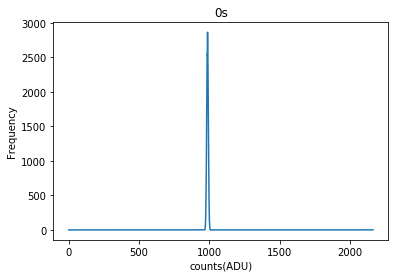

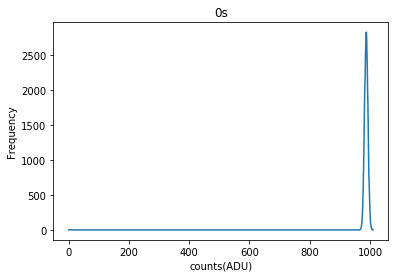

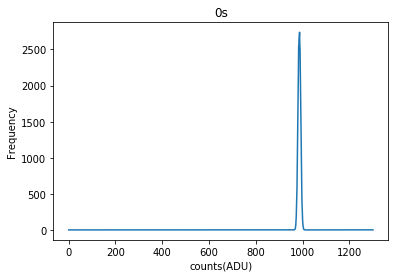

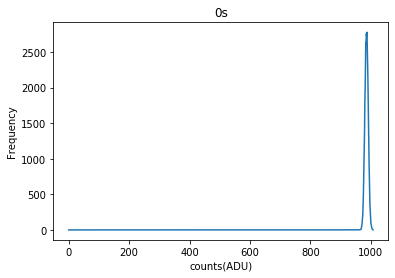

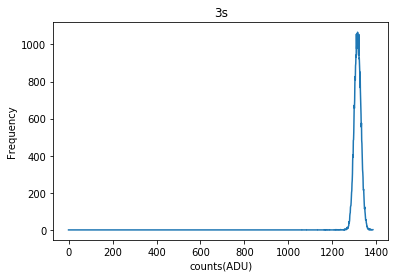

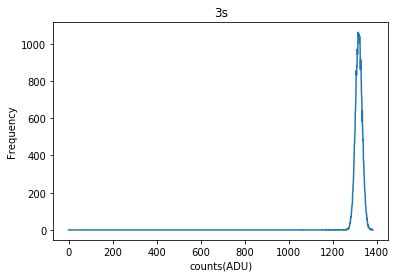

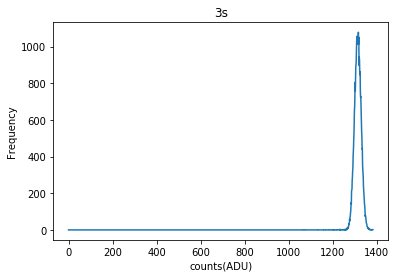

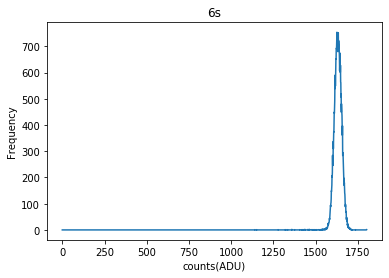

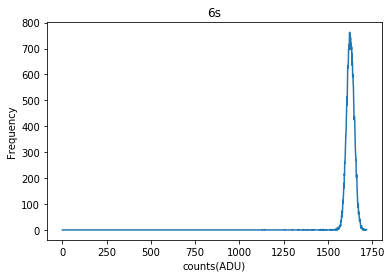

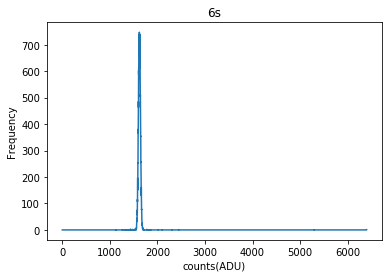

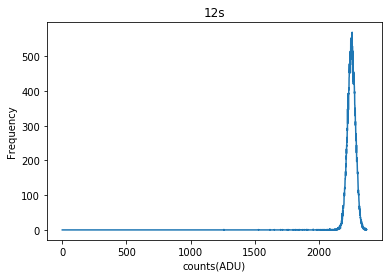

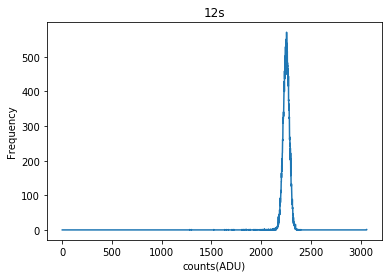

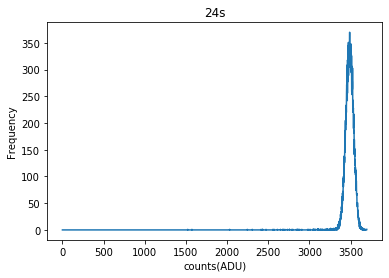

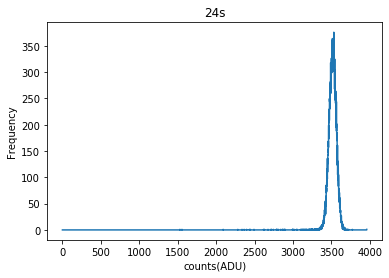

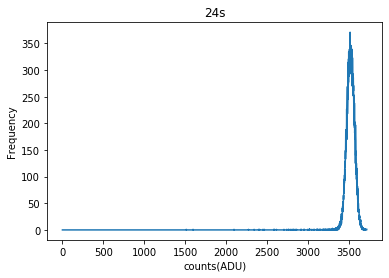

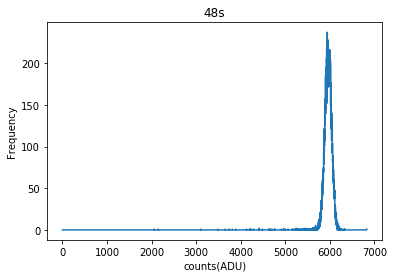

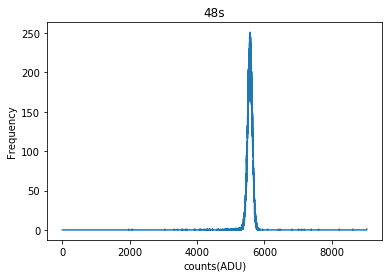

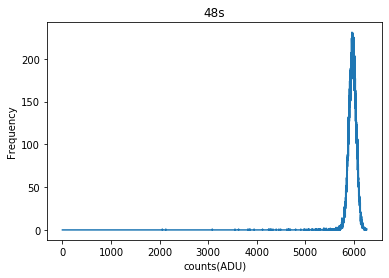

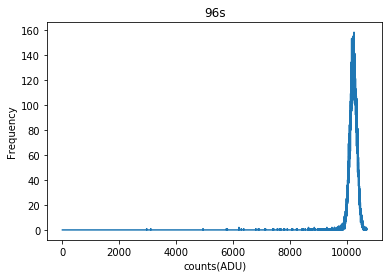

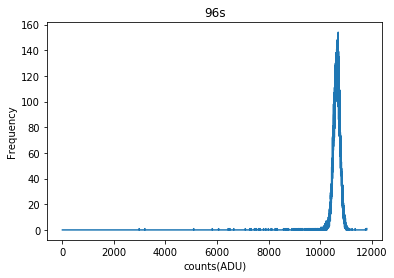

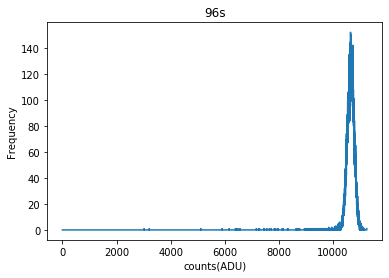

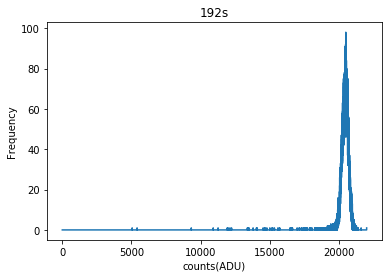

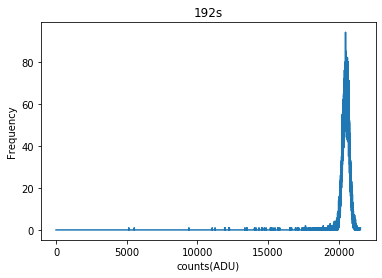

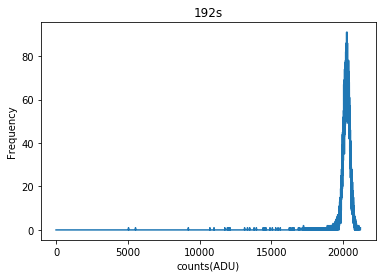

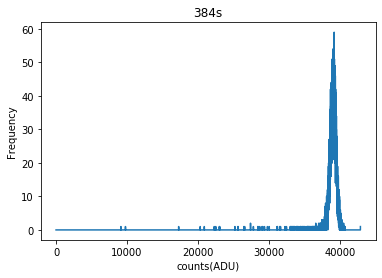

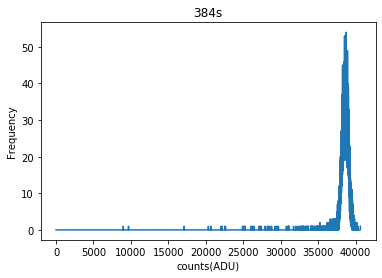

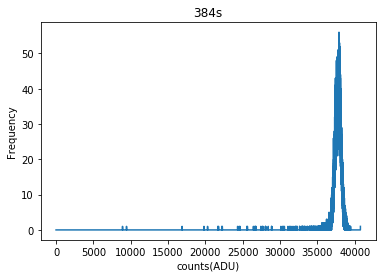

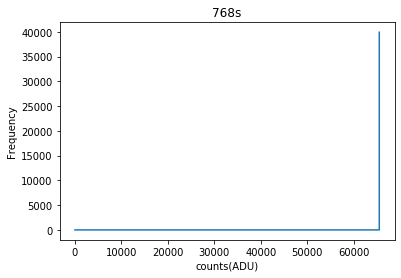

In [61]:
#Plotting a histogram for each image



for j, image in enumerate(images):
    plt.figure()
    data = fits.getdata(image)[400:600,400:600].flatten()
    hmin = 0
    hmax = data.max()
    hr = np.arange(hmin, hmax + 1)
    hist = []
    for i in hr:
        counts = len(np.where(data==i)[0])
        hist.append(counts)
    plt.plot(hr, hist)
    hdu = fits.open(image) #obtain data from FITS file
    header = hdu[0].header #look at file's header
    exp_time = header['EXPTIME'] #find where in the header the exposure time is located
    plt.title(str(exp_time) + 's')
    plt.xlabel('counts(ADU)')
    plt.ylabel('Frequency')
    plt.savefig(str(j))
    plt.show()
    
#Image #28 is not much of a histogram, but we won't be using it anyway.

In [8]:
reduced_images = images[0:27]
reduced_clean_data_list = clean_data_list[0:27]
#I don't want to use the last image because it's very saturated, so I'll make a new list of 1-27

## Bias Subtraction

In [9]:
#Taking the average of the 4 bias frames to subtract from the rest of the frames

bias_average = 1/4 * (reduced_clean_data_list[0] + reduced_clean_data_list[1] + reduced_clean_data_list[2] + reduced_clean_data_list[3])

In [15]:
bias_subtracted = []
#Now, I will subtract the bias average from the other dome flats and save them to this list.

for image in reduced_clean_data_list[4:27]:
    bias_subtracted.append(image - bias_average)

In [19]:
#Building functions to calculate means and standard deviations

def mean(image):
    #Calling each input "image" even though they will be 1d lists.
    
    total = 0
    #Saving a blank integer value that I will add each pixel's value to to get the total brightness for each image.
    
    for pixel in image:
        total += pixel
    
    return total/len(image)
        #len(image) is the total number of pixels
    
means = []

for image in reduced_clean_data_list:
    means.append(mean(image))


def std(image, mean):
    #Calling each input "image" even though they will be 1d lists.
    #The second argument will come from the list of means calculated from the previous function.
    
    total = 0
    #Saving a blank integer value that I will add each pixel's squared difference from the mean to.
    
    for pixel in image:
        total += (pixel - mean)**2
    
    return (total/len(image))**(1/2)
        #len(image) is the total number of pixels
    
    
stds = []

for (image, mean) in zip(reduced_clean_data_list, means):
    #This zipped list will pair each image with its mean.
    
    stds.append(std(image, mean))

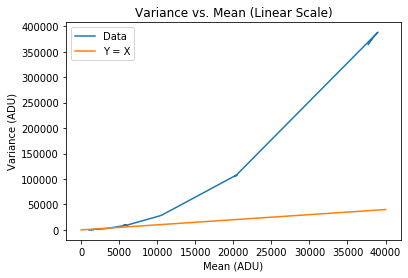

In [68]:
#plotting the standard deviation of each image by variance

plt.plot(means, np.square(stds), label = 'Data')

x = np.linspace(0,40000, 100)
plt.plot(x, x, linestyle='solid', label = 'Y = X')
plt.xlabel('Mean (ADU)')
plt.ylabel('Variance (ADU)')
plt.legend()
plt.title('Variance vs. Mean (Linear Scale)')
plt.savefig('linscale')

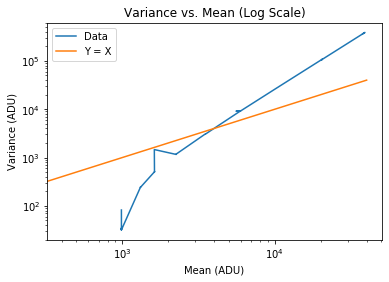

In [69]:
#Repeating the process on a log-scale

plt.plot(means, np.square(stds), label = 'Data')

x = np.linspace(0,40000, 100)
plt.plot(x, x, linestyle='solid', label = 'Y = X')
plt.xlabel('Mean (ADU)')
plt.ylabel('Variance (ADU)')
plt.legend()
plt.title('Variance vs. Mean (Log Scale)')
plt.xscale('log')
plt.yscale('log')
plt.savefig('logscale')

## MOM and SDOM

In [13]:
#Saving the list of exposure times for the relevant files
exp_times = []


for image in images[4:27]:
    hdu = fits.open(image) #obtain data from FITS file
    header = hdu[0].header #look at file's header
    exp_time = header['EXPTIME'] #find where in the header the exposure time is located
    exp_times.append(exp_time)

In [16]:
#Now, I will divide each array by exposure time and save those arrays into this list
averaged_frames = []

for image, time in zip(bias_subtracted, exp_times):
    averaged_frames.append(image/time)

In [17]:
#Each mean of the averaged frames is saved here
time_independent_means = []

for frame in averaged_frames:
    mean = np.sum(frame)/np.size(frame)
    time_independent_means.append(mean)

In [73]:
#Saving the means of means per frame here
means_of_means = []

for i in range(1, len(time_independent_means) + 1, 1):
    means_of_means.append(sum(time_independent_means[:i])/(i+1))

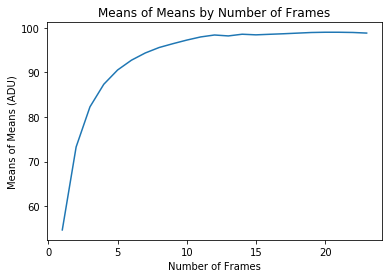

In [74]:
#Plotting the means of means per frame

plt.plot(np.linspace(1, 23, 23), means_of_means)
plt.xlabel('Number of Frames')
plt.ylabel('Means of Means (ADU)')
plt.title('Means of Means by Number of Frames')
plt.savefig('MOM')

In [20]:
#Saving the standard deviation for each bias-subtracted dome flat into this list
stds_list = []

for image, mean in zip(averaged_frames, time_independent_means):
    stds_list.append(std(image, mean))
    

In [21]:
std_of_means = []

for i in range(1, len(time_independent_means) + 1, 1):
    std_of_means.append(np.sqrt((sum(np.square(stds_list[:i])/(i+1)**2))))

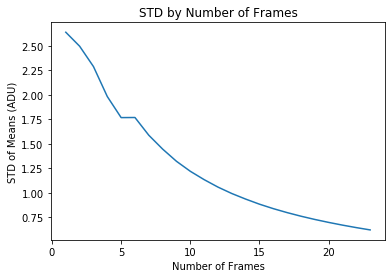

In [77]:
#Plotting the std of means per frame

plt.plot(np.linspace(1, 23, 23), std_of_means)
plt.xlabel('Number of Frames')
plt.ylabel('STD of Means (ADU)')
plt.title('STD by Number of Frames')
plt.savefig('std')

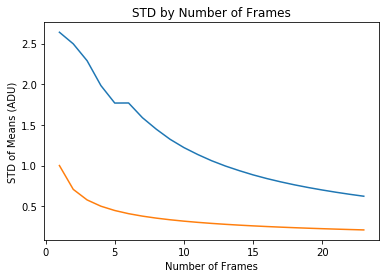

In [78]:
#Plotting the std of means per frame

x = np.linspace(1, 23, 23)
plt.plot(np.linspace(1, 23, 23), std_of_means)
plt.plot(x, 1/np.sqrt(x))
plt.xlabel('Number of Frames')
plt.ylabel('STD of Means (ADU)')
plt.title('STD by Number of Frames')
plt.savefig('stdsqrt')

# Poisson Distribution 


In [94]:
import scipy.stats as stats
from scipy.stats import poisson
from scipy.stats import norm

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


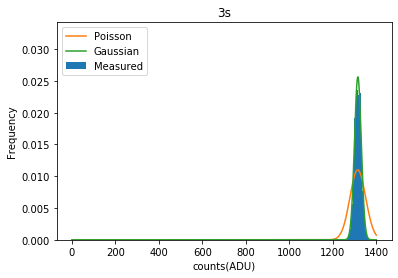

In [109]:
plt.figure()

#Histogram for 3 second exposure
short = fits.getdata('d5.fits')[400:600,400:600].flatten()
plt.hist(short, label = 'Measured', normed = True, bins = 100)

hdu = fits.open('d5.fits') #obtain data from FITS file
header = hdu[0].header #look at file's header
exp_time = header['EXPTIME'] #find where in the header the exposure time is located


#plotting the poisson
x = np.arange(0, 1400, 1)
y = poisson.pmf(x, mu= np.sum(short)/np.size(short))
plt.plot(x, y, label = 'Poisson')


gauss = norm.pdf(x, np.sum(short)/np.size(short), std(short,np.sum(short)/np.size(short)))
plt.plot(x, gauss, label = 'Gaussian')

plt.title(str(exp_time) + 's')
plt.xlabel('counts(ADU)')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('poisson_short')
plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


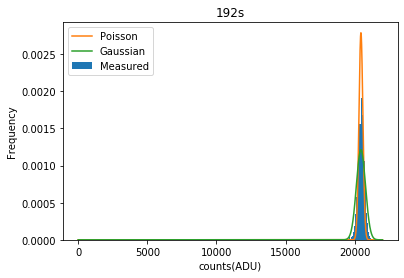

In [110]:
#Repeating for long exposure

plt.figure()

#Histogram for 192 second exposure
long = fits.getdata('d22.fits')[400:600,400:600].flatten()
plt.hist(long, label = 'Measured', normed = True, bins = 1500)
hdu = fits.open('d22.fits') #obtain data from FITS file
header = hdu[0].header #look at file's header
exp_time = header['EXPTIME'] #find where in the header the exposure time is located


#plotting the poisson
x = np.arange(0, 22010, 1)
y = poisson.pmf(x, mu= np.sum(long)/np.size(long))
plt.plot(x, y, label = 'Poisson')


gauss = norm.pdf(x, np.sum(long)/np.size(long), std(long,np.sum(long)/np.size(long)))
plt.plot(x, gauss, label = 'Gaussian')

plt.title(str(exp_time) + 's')
plt.xlabel('counts(ADU)')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('poisson_long')
plt.show()

# Mikaela's Functions for Distributions

In [105]:
def P(x, m):
#For the Poisson Distribution
    stir = np.sqrt(2 * np.pi * x) * (x / np.exp(1)) ** x #Stirling's approximation
    return (m**x * np.exp(-m))/stir

In [106]:
def G(x, m, s): 
#For the Gaussian Distribution
    return (s*np.sqrt(2*np.pi)) ** -1 *np.exp(-(1/2)*((x-m)/s)**2)

# Calculating Readnoise

No handles with labels found to put in legend.


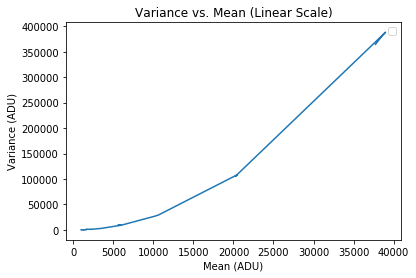

In [27]:
#Plotting variance versus means and curve fitting to read readnoise

plt.plot(means, np.square(stds))

x = np.linspace(0,40000, 100)
plt.xlabel('Mean (ADU)')
plt.ylabel('Variance (ADU)')
plt.legend()
plt.title('Variance vs. Mean (Linear Scale)')
plt.savefig('linscale')